<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod4/dr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod4/dr.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Dimensionality Reduction
---
_homl3 ch8_

- The Curse of Dimensionality
- Main Approaches for Dimensionality Reduction
- Projection
- PCA
- Random Projection
- LLE
- Other Dimensionality Reduction Techniques

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

# The Curse of Dimensionality
- problems caused by too many features for each instances
  - extremely slow to train and validate ML models on these datasets
  - very difficult to find a good solution
- Many real-world datasets have thousands even millions of features
  - but often it is possible to reduce the number of features considerably
    - this turns an intractable problem into a tractable one
    - makes it possible to plot a condensed view of a high-dimensional training set
      - in 2D or 3D spaces
    - helps gain some important insights by visually detecting patterns
      - such as clusters
- There are three popular dimensionality reduction techniques: 
  - PCA, random projection, and locally linear embedding (LLE)

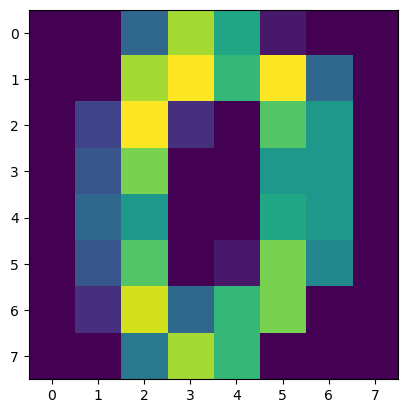

In [3]:
# 1. An example of reducing the number of features
# A compressed MNIST dataset of handwritten digits
# 
# each digit is an 8 by 8 black-white image
# 1.1 the border pixels can be dropped without losing too much information
# 1.2 the importance of each pixel can be shown with a random forest
#     two neighboring pixels are often highly correlated
#     not too much information will be lost if they were merged into a single pixel

X, y = skds.load_digits(return_X_y=True)
plt.imshow(np.reshape(X[:1],(8,8)))

## Problems Of Reducing Dimensionality
- cause some information loss
- make the ML system perform slightly worse even though it will speed up training
- make ML pipelines a bit more complex and thus harder to maintain

## An Unit [Spacelet](https://en.wikipedia.org/wiki/Hypercube) In Spaces Of Different Dimensions
| # of dimensions | spacelet with sides of 1 unit |
|:---:|:---:|
| 0 | point |
| 1 | an unit segment | 
| 2 | an unit square |
| 3 | an unit cube |
| ≥ 4 | hypercubes |

- many things behave very differently in high-dimensional space
   - the longest diagonal in a n-cube is $\sqrt{n}$
   - the [distance d(n)](https://en.wikipedia.org/wiki/Mean_line_segment_length) between two random selected points in n-cube increases when n increases
     - $d(2) \approx 0.52$
     - $d(3) \approx 0.66$
     - $d(1,000,000) \approx 370.79$
     - ∴ high-dimensional datasets are at risk of being very sparse
       - great risk of overfitting
       - new instances will likely be far away from any training instance
   - most points in a high-dimensional hypercube are very close to the border
- one solution to the curse of dimensionality could be to increase the size of the training set
  - but  the number of training instances required to reach a given density grows exponentially with the number of dimensions


# Main Approaches for Dimensionality Reduction

# Projection

## Manifold Learning

# PCA
## Preserving the Variance
## Principal Components
## Projecting Down to d Dimensions
## Using Scikit-Learn
## Explained Variance Ratio
## Choosing the Right Number of Dimensions
## PCA for Compression
## Randomized PCA
## Incremental PCA

# Random Projection

# LLE

# Other Dimensionality Reduction Techniques